In [ ]:
import numpy as np
from math import sqrt, exp
from numpy import linalg as LA
import datetime
import tracemalloc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
import warnings

In [ ]:
DEFAULT_EPS = 1e-6

In [ ]:
def dichotomy(f, eps=DEFAULT_EPS, print_i=False):
    delta = eps / 3
    def step(old_interval, cnt=0):        
        a, b = old_interval
        mid = (a + b) / 2
        
        if b - a < eps:
            if print_i: 
                print_ans(mid, cnt, cnt * 2, eps)

            return mid
         
        x1, x2 = mid - delta, mid + delta
        fx1, fx2 = f(x1), f(x2)

        if fx1 < fx2:
            new_interval = (a, x2)
        elif fx1 > fx2:
            new_interval = (x1, b)
        else:
            new_interval = (x1, x2)

        if print_i: 
            print_info(old_interval, new_interval, cnt, cnt * 2 + 2)

        return step(new_interval, cnt+1)

    return step
  



In [ ]:
phi = (sqrt(5) - 1) / 2

def golden_ratio(f, eps=DEFAULT_EPS, print_i=False):
    def step(old_interval, f_x1=None, f_x2=None, cnt=0):
        a, b = old_interval

        if b - a < eps:
            mid = (a + b) / 2
            if print_i: 
                print_ans(mid, cnt, cnt + 1, eps)

            return mid

        t = (b - a) * phi
        x1, x2 = b - t, a + t

        f_x1 = f_x1 if f_x1 else f(x1)
        f_x2 = f_x2 if f_x2 else f(x2)

        if f_x1 < f_x2:
            new_interval = (a, x2)
            args = [None, f_x1]
        else:
            new_interval = (x1, b)
            args = [f_x2, None]
            
        if print_i: 
            print_info(old_interval, new_interval, cnt, cnt + 1)

        return step(new_interval, *args, cnt + 1)
        
    return step

In [ ]:
def evaluate_kth_fib(interval, eps):
    a, b = interval
    t = (b - a) / eps
    kth_fib, next_fib = [1], 1

    while kth_fib[-1] < t:
        kth_fib.append(next_fib)
        next_fib += kth_fib[-2]     

    return kth_fib

def fibonacci(f, eps=DEFAULT_EPS, print_i=False):
    def step(old_interval, kth_fib=None, n=None, x1=None, x2=None, f_x1=None, f_x2=None, cnt=0):     
        a, b = old_interval

        if not kth_fib:
            kth_fib = evaluate_kth_fib(old_interval, eps) 
            n = len(kth_fib) - 1
            x1 = a + kth_fib[n - 2] / kth_fib[n] * (b - a)
            x2 = a + kth_fib[n - 1] / kth_fib[n] * (b - a)
            f_x1, f_x2 = f(x1), f(x2)

        if n <= 2:
            mid = (a + b) / 2
            if (print_i): 
                print_ans(mid, cnt, cnt + 1, eps)

            return mid

        n -= 1 

        if f_x1 < f_x2:
            b, x2, f_x2 = x2, x1, f_x1
            x1 = a + kth_fib[n - 2] / kth_fib[n] * (b - a)
            f_x1 = f(x1)
        else:
            a, x1, f_x1 = x1, x2, f_x2
            x2 = a + kth_fib[n - 1] / kth_fib[n] * (b - a)
            f_x2 = f(x2)

        if (print_i): 
            print_info(old_interval, (a, b), cnt, cnt + 1)

        return step((a, b), kth_fib, n, x1, x2, f_x1, f_x2, cnt + 1)
      
    return step

In [ ]:
def stop(xk, x0, eps, derivative):
    return LA.norm(derivative(*xk)) ** 2 <= eps * LA.norm(derivative(*x0)) ** 2

def stop_soft(x_cur, x_prev, eps):
    return LA.norm(x_cur - x_prev) < eps

def linear_search(f):
    step = 1e-3
    right_border = step

    while f(0) >= f(right_border):
        right_border += step

    return right_border

def find_best_step(f, xk, method, derivative):
    g = lambda step: f(*(xk - step * derivative(*xk)))
    interval = 0, linear_search(g)
    return method(g)(interval)

def gradient_descent(f, derivative, method, x0, n=2, iteration=10_000, eps=1e-10, step=None):
    tracemalloc.start()
    start = datetime.datetime.now()
    xk = x0
    trace = [xk]
    cnt = 0
    for _ in range(iteration):
        lr = step if step else find_best_step(f, xk, method, derivative)  
        x_prev = xk  
        xk = xk - lr * derivative(*xk)
        trace.append(xk)
        cnt += 1
        if stop_soft(xk, x_prev, eps):
            break
    _, peak = tracemalloc.get_traced_memory()
    end = datetime.datetime.now()        
    tracemalloc.stop()
    return cnt, end - start, peak / 10 ** 3, xk, np.asarray(trace)

In [ ]:
def plot_graph(f, trace):
    fig, ax = plt.subplots()

    x, y = np.mgrid[-8:10:1000j, -10:12:1000j]
    z = f(x, y)

    levels = [x ** 3 for x in range(8)]
    r = np.linspace(240, 166, 256) / 255.
    g = np.linspace(244, 188, 256) / 255.
    b = np.linspace(246, 203, 256) / 255.
    cmap = ListedColormap(np.vstack((r, g, b)).T)

    ax.contourf(x, y, z, levels = 10, cmap = cmap)
    cs = ax.contour(x, y, z, levels = levels, colors = "#ABBECC")
    ax.clabel(cs, colors = "#2618B1")

    ax.plot(trace[:, 0], trace[:, 1], '-og', linewidth=.5, ms=1.5)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()

    fig.set_figwidth(10)
    fig.set_figheight(12)

    plt.show()


In [ ]:
def conjugate_gradient(f, derivative, x0, method, iteration=10_000, eps=1e-10):
    tracemalloc.start()
    start = datetime.datetime.now()
    xk = x0
    ws = [-derivative(*x0)]
    ps = [-derivative(*x0)]
    trace = [xk]
    def step(x, ws, ps):
       ws.append(-derivative(*x))
       bk = (ws[-1] @ ws[-1]) / (ws[-2] @ ws[-2])
       pk = ws[-1] + bk * ps[-1]
       ps.append(pk)

       g = lambda a: f(*(x + a * pk))
       ak = method(g)((0, 1.01))
       x_next = x + ak * pk

       return x_next, ws, ps
    
    for i in range(iteration):
        x_next, ws, ps = step(xk, ws, ps)
        trace.append(x_next)
        if (x_next @ x_next > 1e10):
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end = datetime.datetime.now()
            return i, end - start, peak / (10 ** 3), np.asarray(trace), None
            break

        if (LA.norm(derivative(*x_next)) < eps):
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end = datetime.datetime.now()
            return i, end - start, peak / (10 ** 3), np.asarray(trace), x_next

        xk = x_next


In [ ]:
def positive_qform(matrix):
    if (np.all(LA.eigvals(matrix) > 0)):
        return matrix
    l = LA.eigvals(matrix)
    mu = (-l + 1) * np.eye(matrix.shape[0])
    return matrix + mu

def newton(f, derivative, hessians, x0, iteration=10_000, eps=1e-10):
    tracemalloc.start()
    start = datetime.datetime.now() 
    x = x0
    trace = [x]
    cnt = 0
    grad = derivative(*x)
    while LA.norm(grad) >= eps and cnt < iteration:
        grad = derivative(*x)
        hessian = hessians(*x)
        hessian = positive_qform(hessian)
        step = grad.dot(LA.inv(hessian))
        x = x - step
        trace.append(x)
        cnt += 1
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = datetime.datetime.now()
    return cnt, end - start, peak / (10 ** 3), np.asarray(trace), x


Вычисляю для f = 5 * (y - x) ^ 2 + (1 - x) ^ 2:
	x0=[0 0]
		 Метод градиентного спуска:


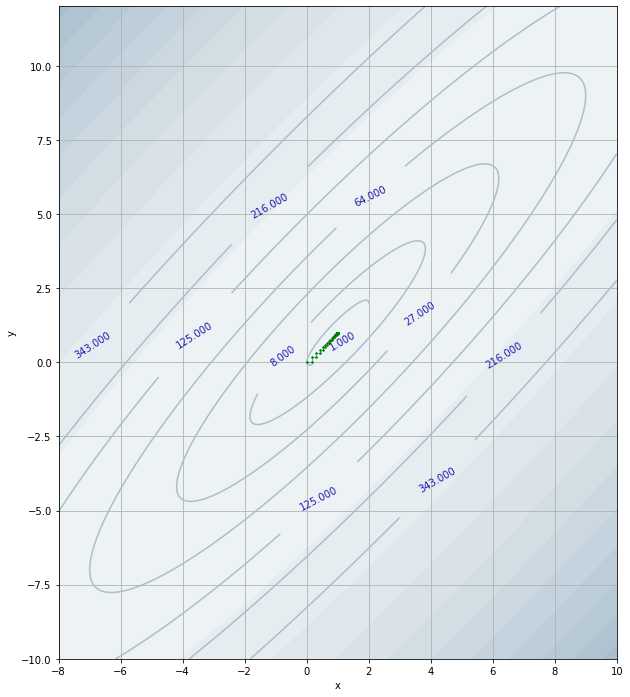

			Ответ : [1. 1.]. Количество итераций : 235. Время : 120795 микросекунд. Память : 98.954 KB
		 Метод сопряженных направлений Флетчера-Ривса:


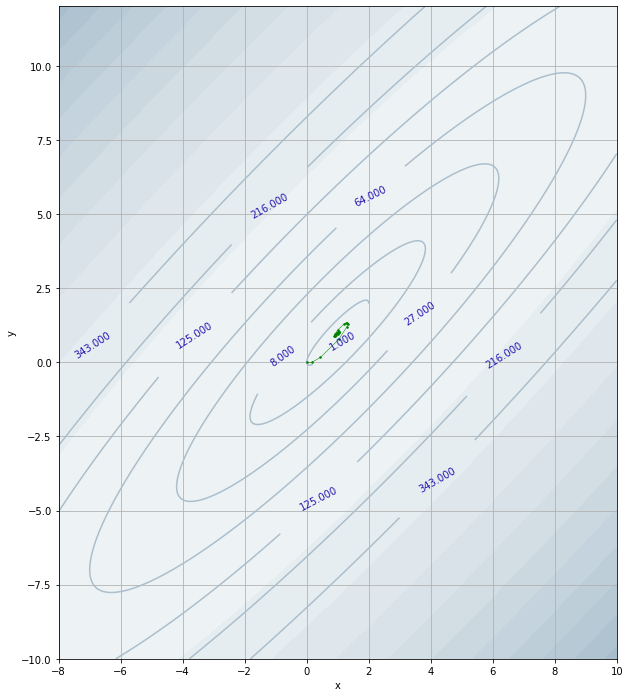

			Ответ : [1.00000431 1.00000441]. Количество итераций : 65. Время : 34104 микросекунд. Память : 76.473 KB

		 Метод Ньютона:


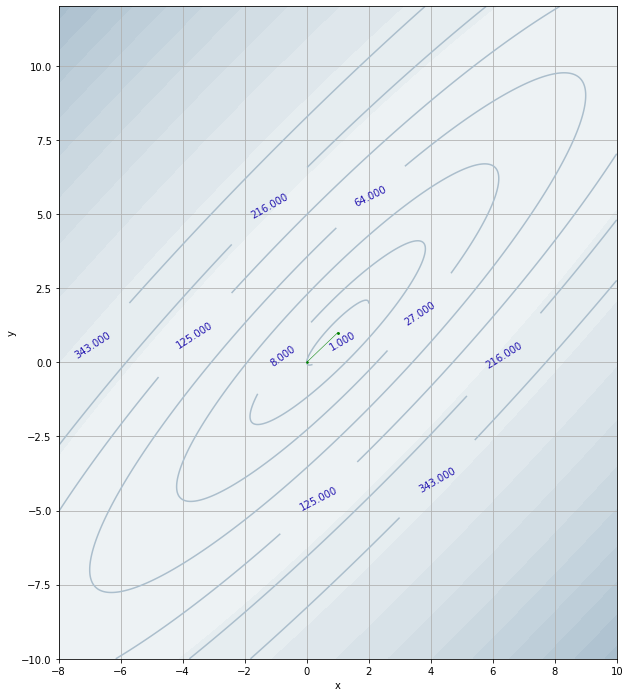

			Ответ:[1. 1.]. Количество итераций : 2. Время : 21976 микросекунд. Память : 1.401 KB
	x0=[-1  1]
		 Метод градиентного спуска:


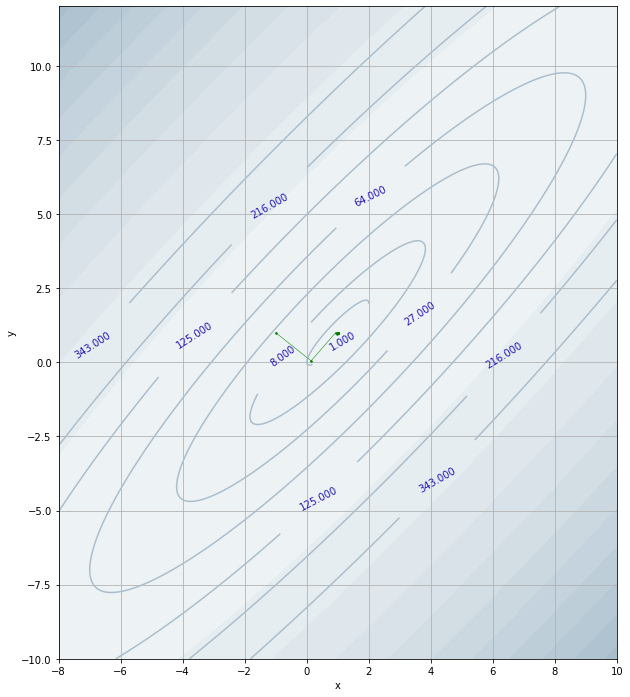

			Ответ : [1. 1.]. Количество итераций : 15. Время : 746840 микросекунд. Память : 78.417 KB
		 Метод сопряженных направлений Флетчера-Ривса:


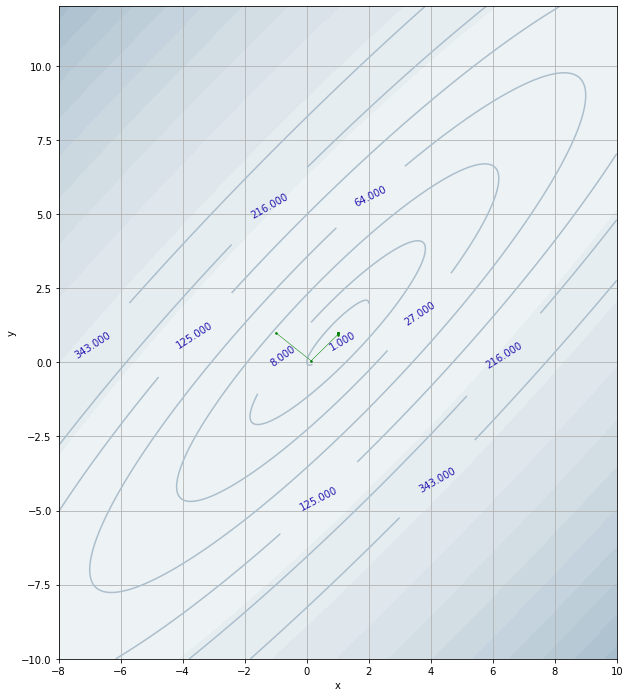

			Ответ : [0.99999997 0.99999996]. Количество итераций : 7. Время : 4446 микросекунд. Память : 12.337 KB

		 Метод Ньютона:


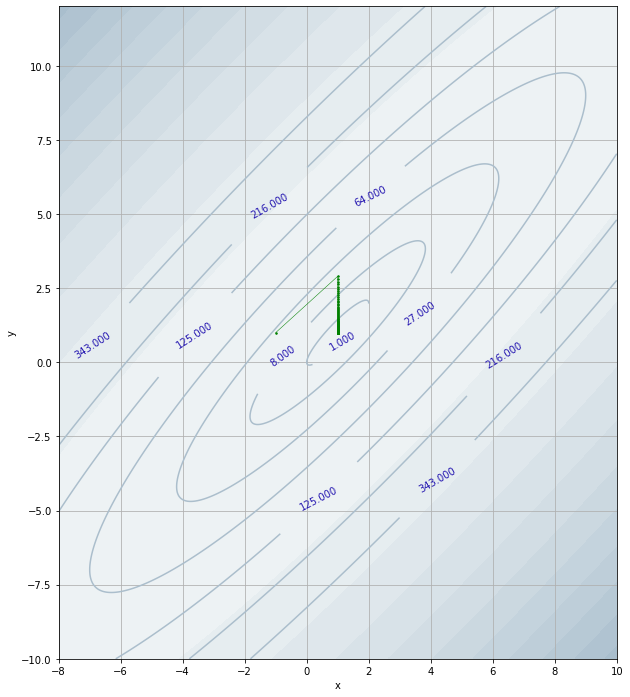

			Ответ:[1.         1.00000066]. Количество итераций : 291. Время : 100446 микросекунд. Память : 60.823 KB
	x0=[2 3]
		 Метод градиентного спуска:


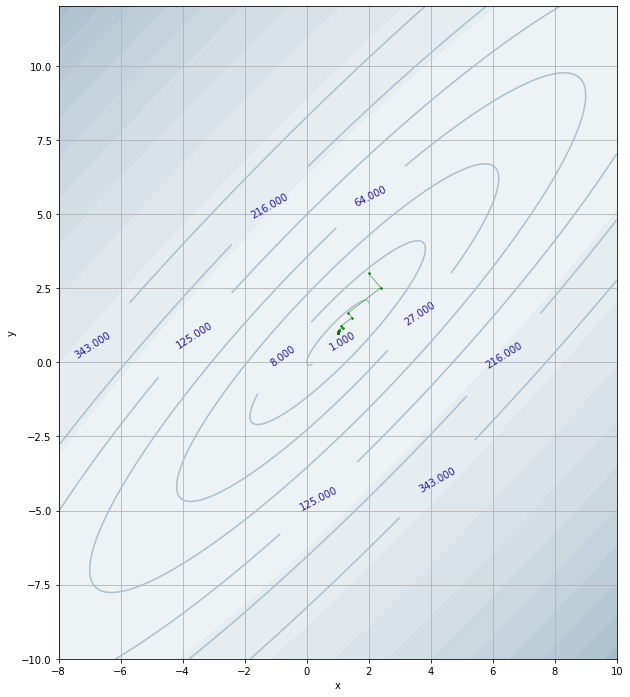

			Ответ : [1. 1.]. Количество итераций : 43. Время : 525598 микросекунд. Память : 92.585 KB
		 Метод сопряженных направлений Флетчера-Ривса:


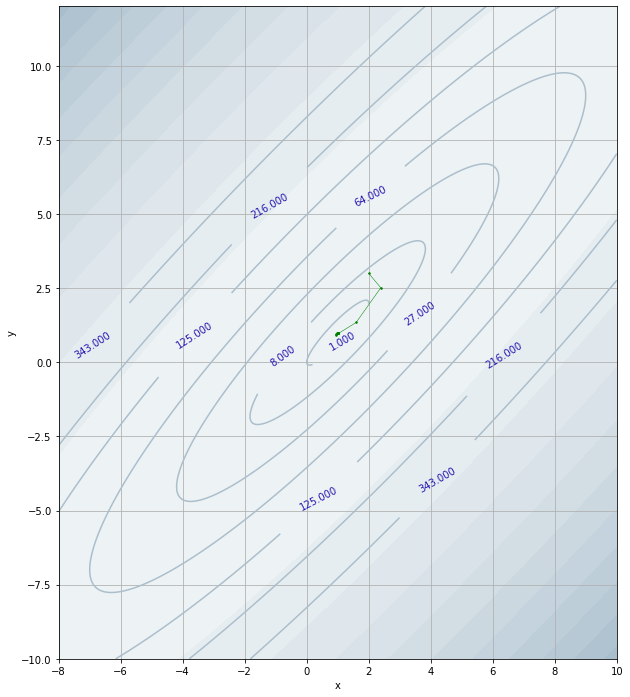

			Ответ : [1.00000383 1.00000429]. Количество итераций : 12. Время : 6741 микросекунд. Память : 16.241 KB

		 Метод Ньютона:


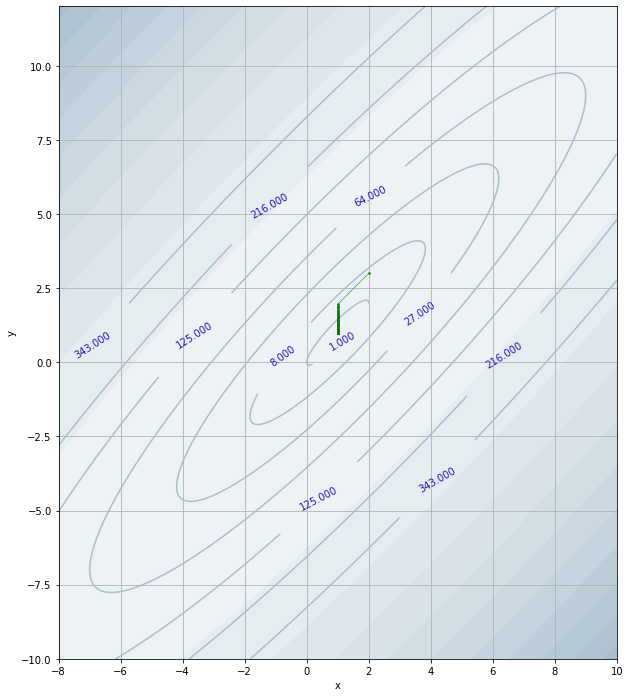

			Ответ:[1.         1.00000064]. Количество итераций : 278. Время : 81411 микросекунд. Память : 39.952 KB
	x0=[4 1]
		 Метод градиентного спуска:


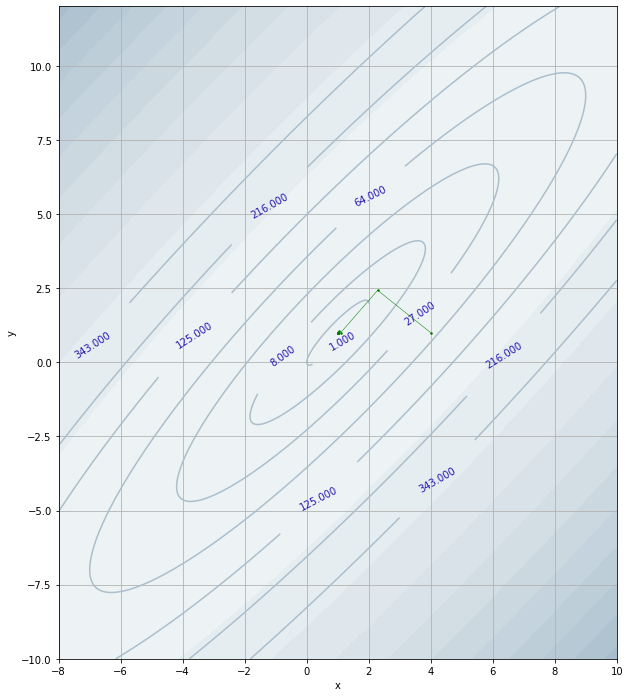

			Ответ : [1. 1.]. Количество итераций : 15. Время : 747117 микросекунд. Память : 65.902 KB
		 Метод сопряженных направлений Флетчера-Ривса:


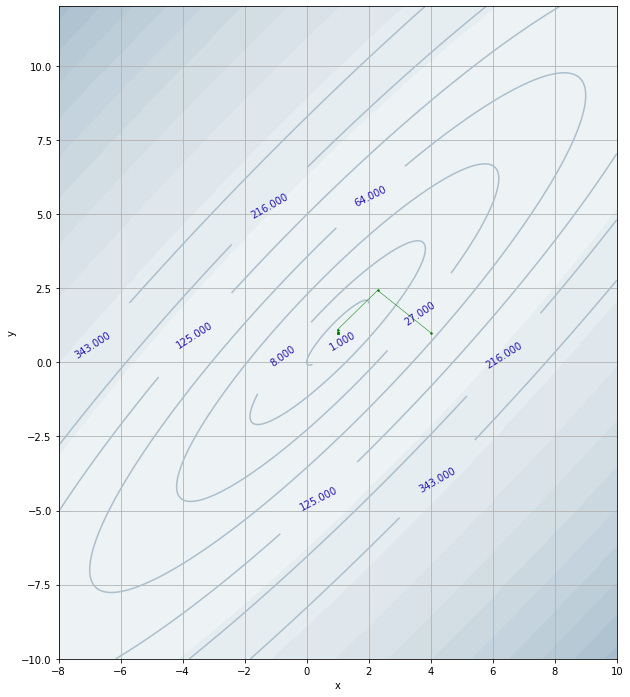

			Ответ : [1.00000004 1.00000005]. Количество итераций : 7. Время : 4555 микросекунд. Память : 23.137 KB

		 Метод Ньютона:


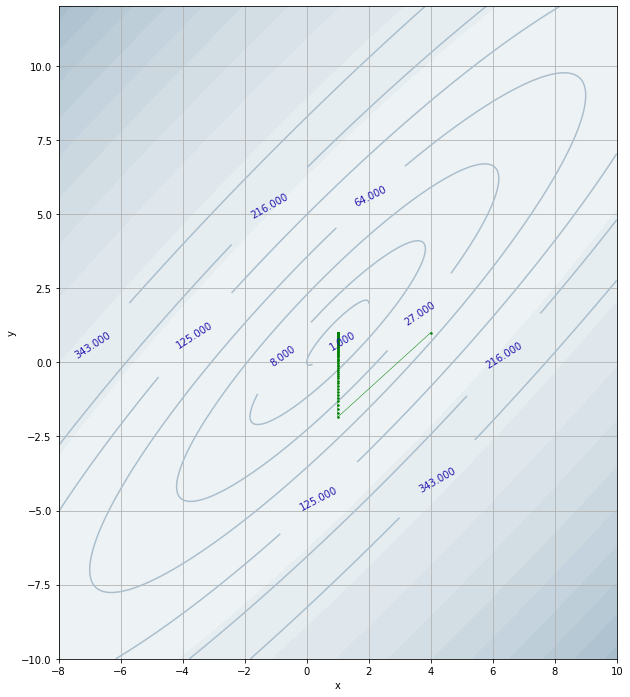

			Ответ:[1.         0.99999934]. Количество итераций : 299. Время : 93316 микросекунд. Память : 41.708 KB
	x0=[3 5]
		 Метод градиентного спуска:


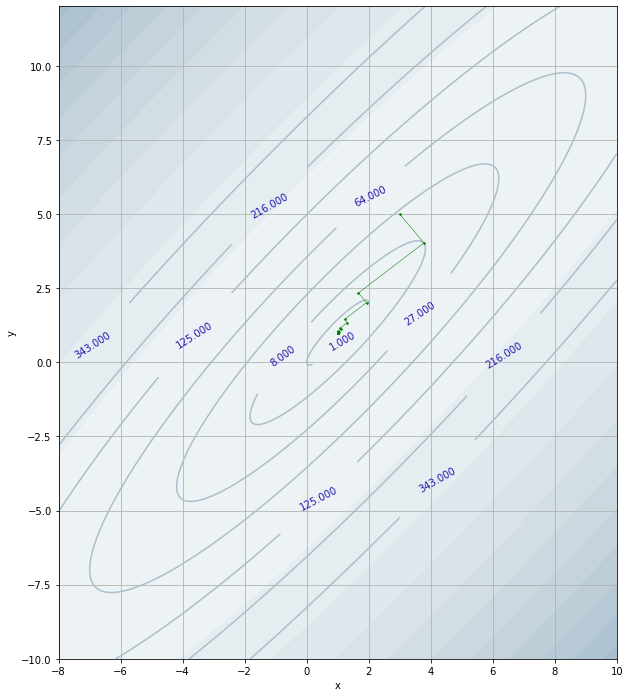

			Ответ : [1. 1.]. Количество итераций : 45. Время : 640854 микросекунд. Память : 75.908 KB
		 Метод сопряженных направлений Флетчера-Ривса:


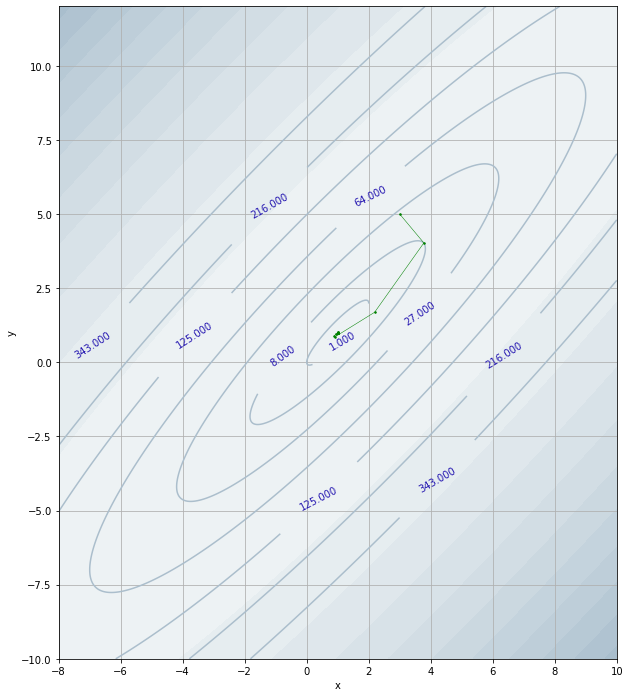

			Ответ : [0.99999984 0.99999957]. Количество итераций : 14. Время : 7727 микросекунд. Память : 20.561 KB

		 Метод Ньютона:


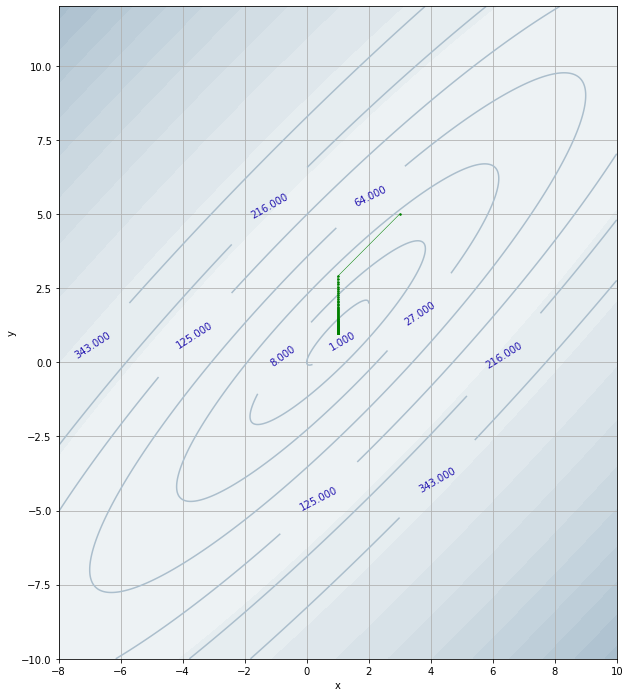

			Ответ:[1.         1.00000066]. Количество итераций : 291. Время : 102515 микросекунд. Память : 41.544 KB
Вычисляю для f = (100 * (y - x ^ 2) ^ 2 + (1 - x) ^ 2):
	x0=[0 0]
		 Метод градиентного спуска:


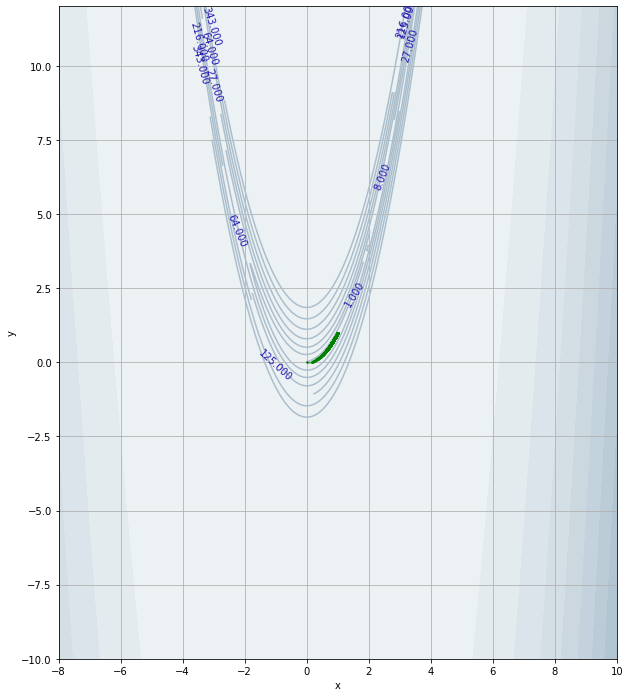

			Ответ : [0.99999777 0.99999555]. Количество итераций : 10000. Время : 904137 микросекунд. Память : 1317.067 KB
		 Метод сопряженных направлений Флетчера-Ривса:


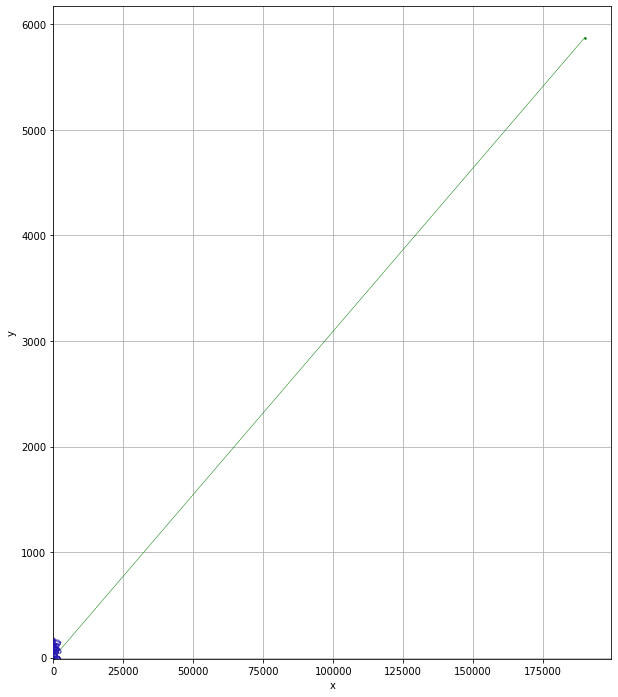

			Ответ : Разошелся. Количество итераций : 592. Время : 345132 микросекунд. Память : 272.782 KB

		 Метод Ньютона:


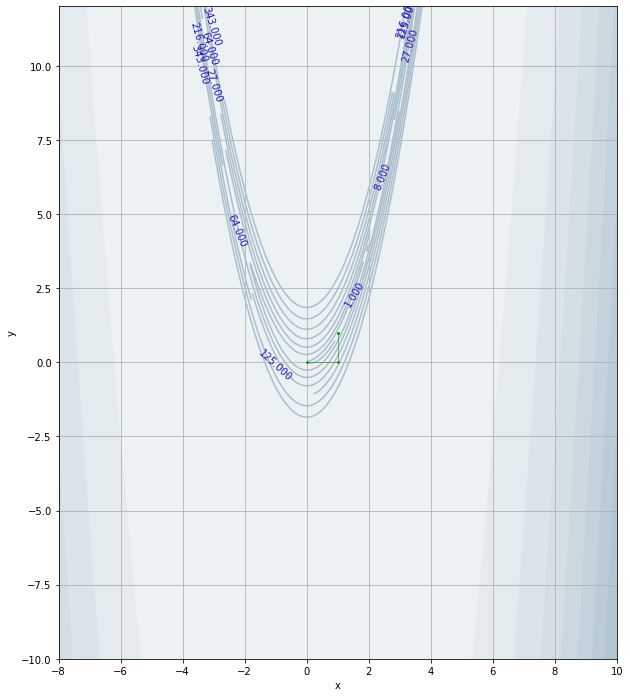

			Ответ:[1. 1.]. Количество итераций : 3. Время : 19548 микросекунд. Память : 4.793 KB
	x0=[-1  1]
		 Метод градиентного спуска:


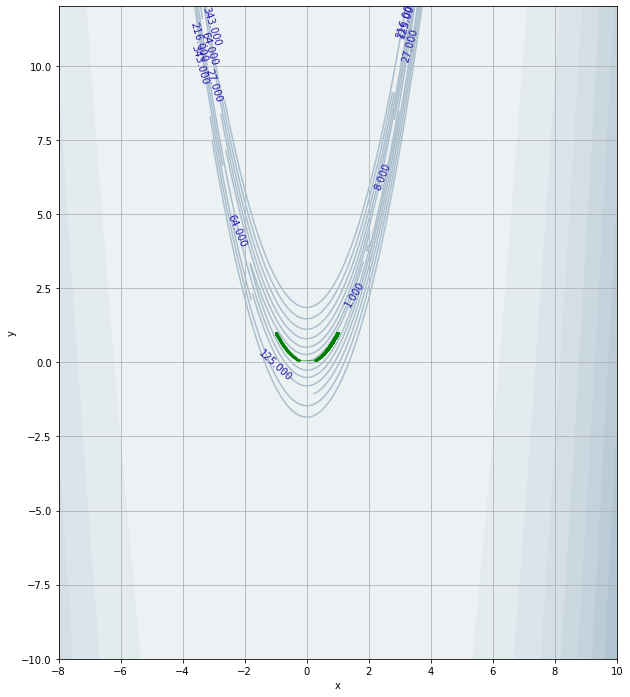

			Ответ : [0.99999888 0.99999775]. Количество итераций : 10000. Время : 320204 микросекунд. Память : 1271.621 KB
		 Метод сопряженных направлений Флетчера-Ривса:


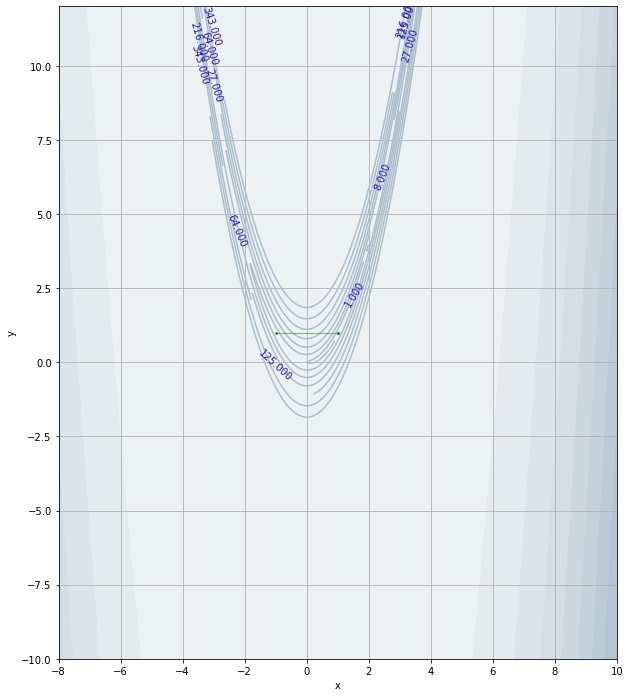

			Ответ : [1.00000012 1.00000024]. Количество итераций : 1. Время : 2410 микросекунд. Память : 9.241 KB

		 Метод Ньютона:


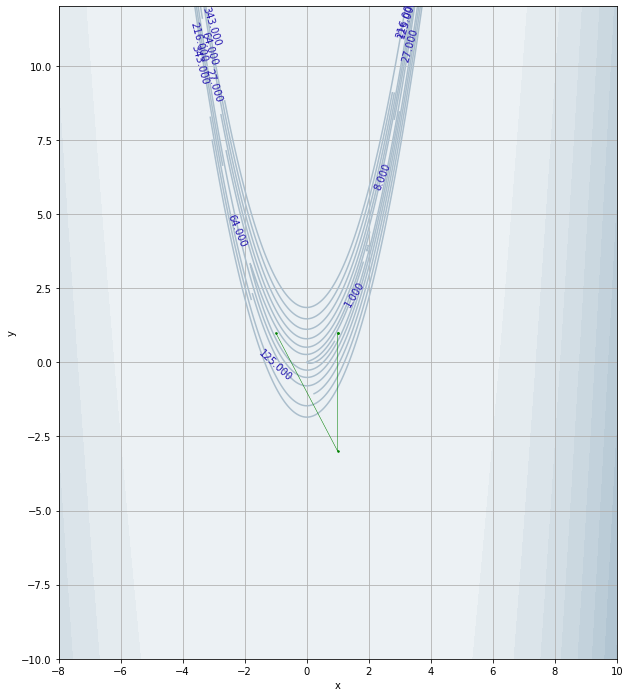

			Ответ:[1. 1.]. Количество итераций : 3. Время : 1197 микросекунд. Память : 1.465 KB
	x0=[2 3]
		 Метод градиентного спуска:


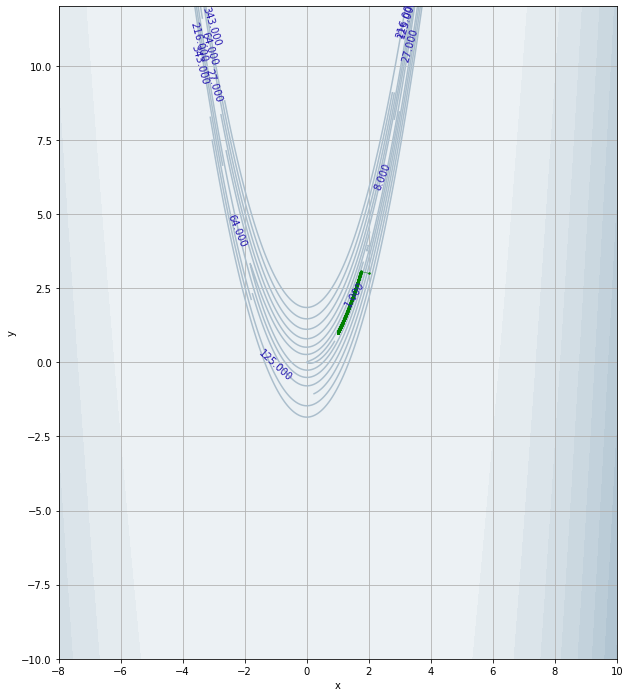

			Ответ : [1.         1.00000001]. Количество итераций : 935. Время : 897731 микросекунд. Память : 269.389 KB
		 Метод сопряженных направлений Флетчера-Ривса:


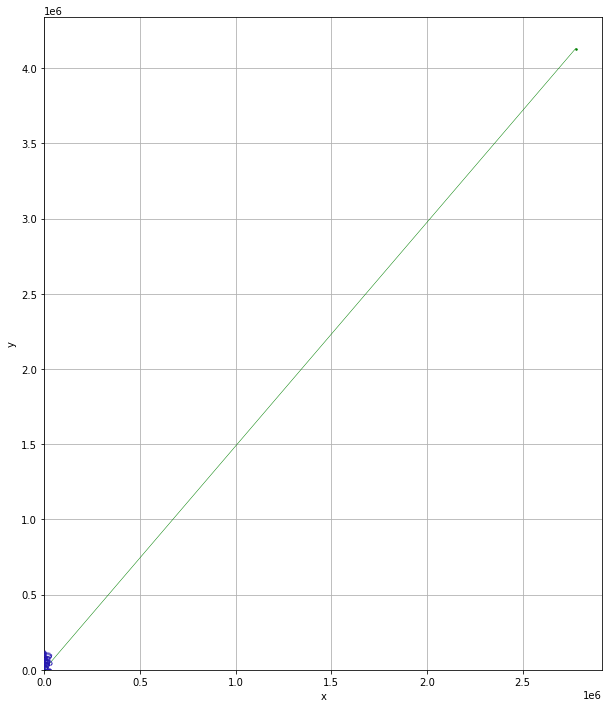

			Ответ : Разошелся. Количество итераций : 706. Время : 402971 микросекунд. Память : 321.205 KB

		 Метод Ньютона:


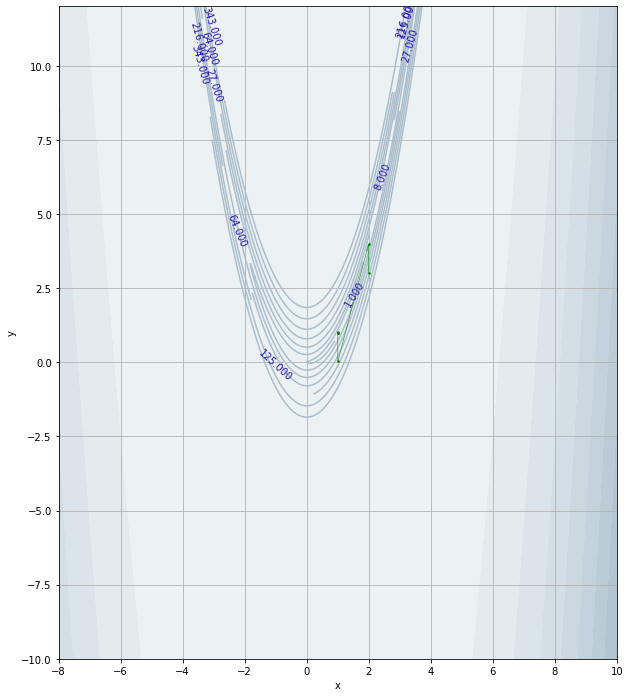

			Ответ:[1. 1.]. Количество итераций : 6. Время : 22840 микросекунд. Память : 1.8 KB
	x0=[4 1]
		 Метод градиентного спуска:


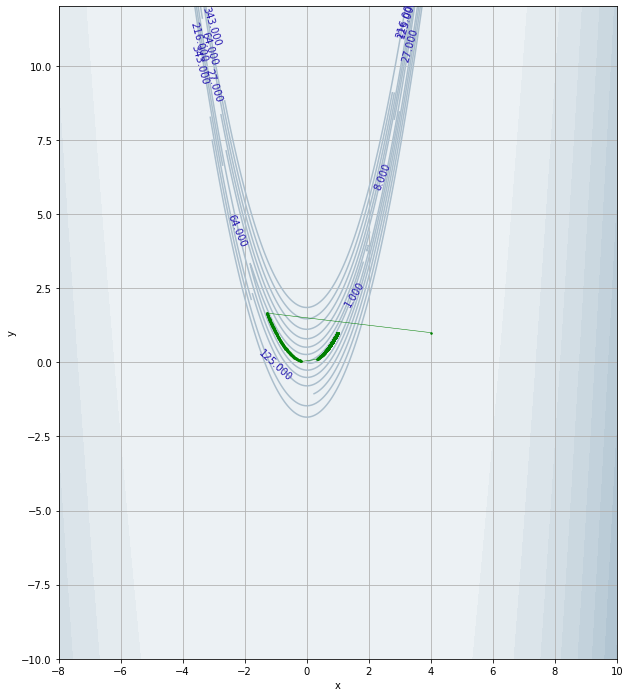

			Ответ : [0.99997165 0.99994314]. Количество итераций : 10000. Время : 351985 микросекунд. Память : 1271.179 KB
		 Метод сопряженных направлений Флетчера-Ривса:


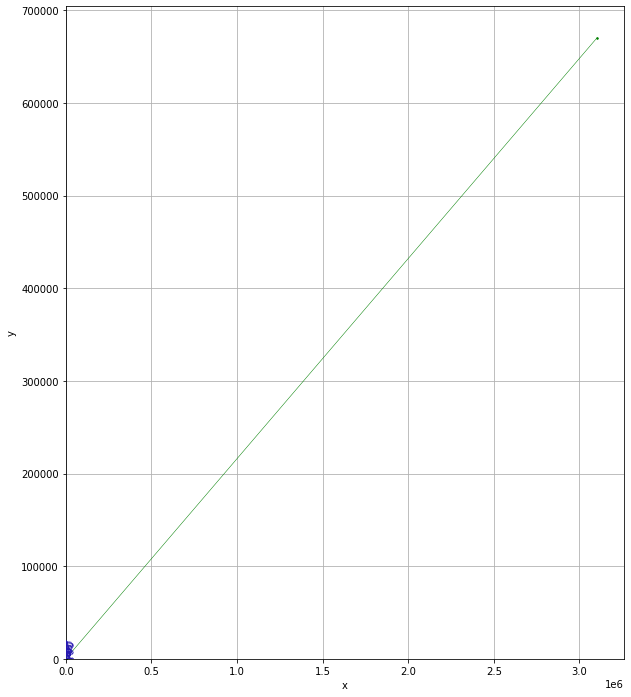

			Ответ : Разошелся. Количество итераций : 641. Время : 382967 микросекунд. Память : 296.631 KB

		 Метод Ньютона:


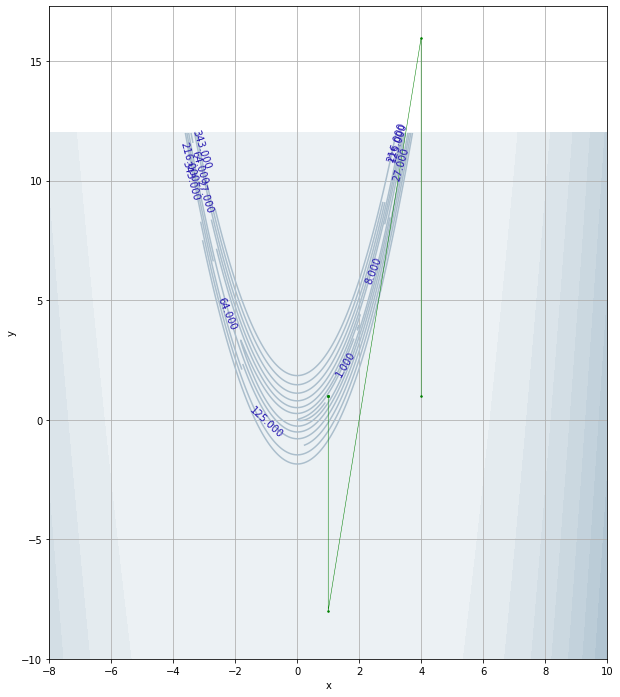

			Ответ:[1. 1.]. Количество итераций : 6. Время : 7709 микросекунд. Память : 1.8 KB
	x0=[3 5]
		 Метод градиентного спуска:


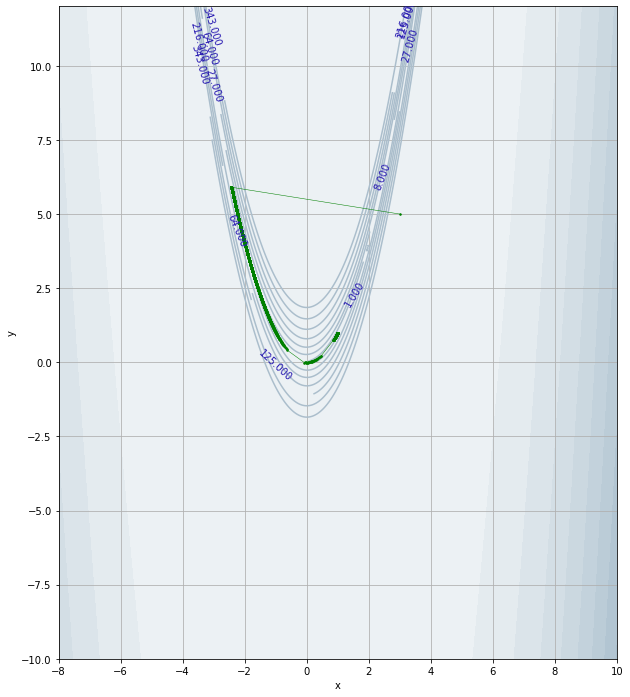

			Ответ : [0.99999997 0.99999994]. Количество итераций : 9778. Время : 389544 микросекунд. Память : 1286.812 KB
		 Метод сопряженных направлений Флетчера-Ривса:


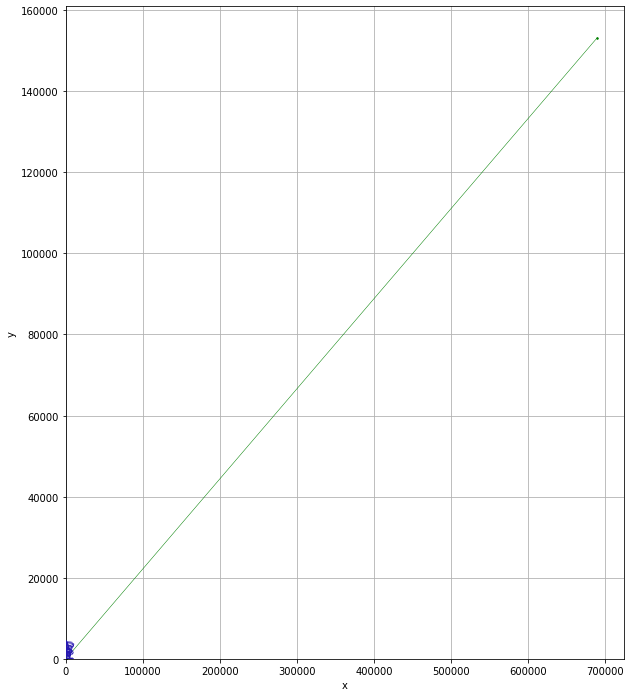

			Ответ : Разошелся. Количество итераций : 718. Время : 425420 микросекунд. Память : 322.837 KB

		 Метод Ньютона:


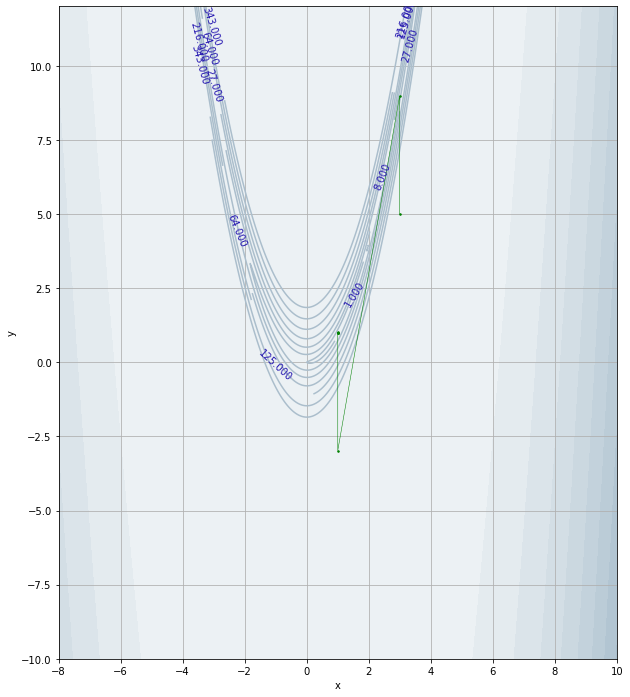

			Ответ:[1. 1.]. Количество итераций : 6. Время : 20086 микросекунд. Память : 6.572 KB
Вычисляю для f = 2 * exp(-((x - 1) / 2) ^ 2 - (y - 1) ^ 2) + 3 * exp(-((x - 2) / 3) ^ 2 - ((y - 3) / 2) ^ 2):
	x0=[0 0]
		 Метод градиентного спуска:


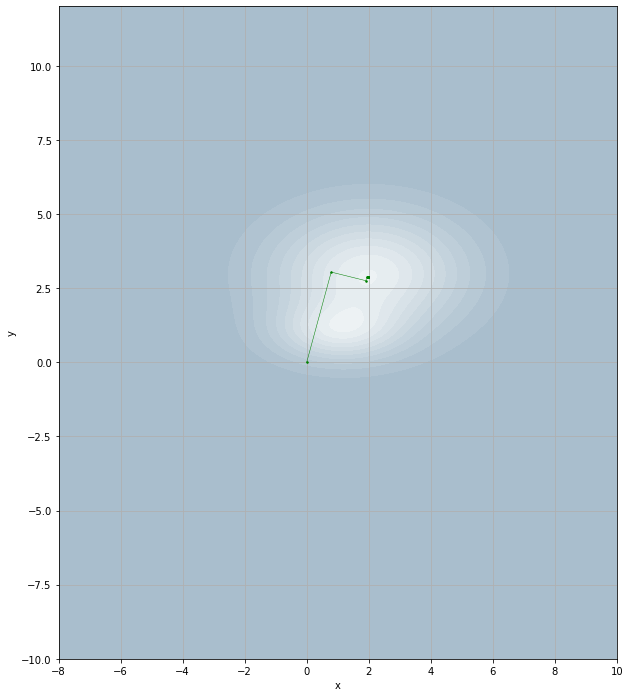

			Ответ : [1.96715142 2.88611462]. Количество итераций : 13. Время : 884150 микросекунд. Память : 89.665 KB
		 Метод сопряженных направлений Флетчера-Ривса:


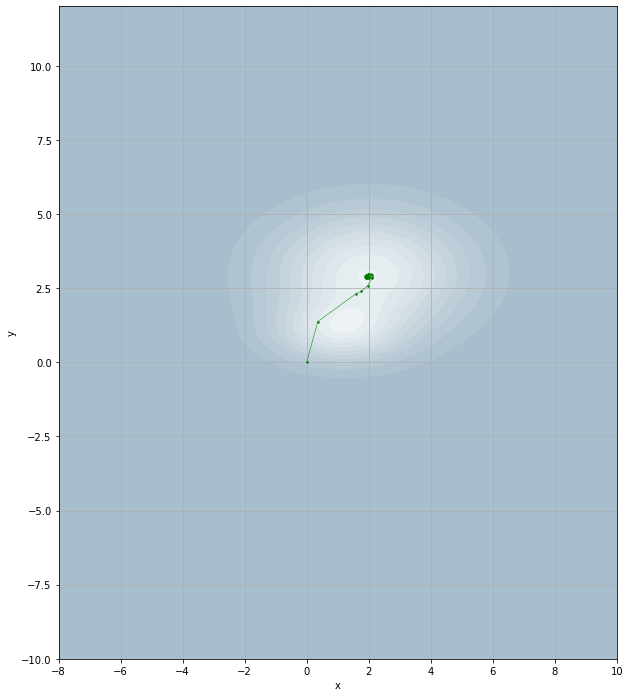

			Ответ : [1.96715583 2.88610531]. Количество итераций : 106. Время : 151037 микросекунд. Память : 97.857 KB

		 Метод Ньютона:


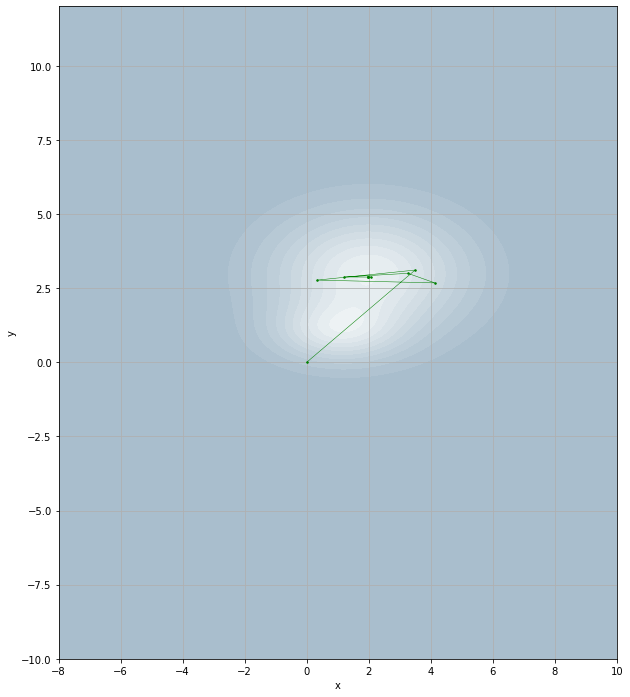

			Ответ:[1.96715142 2.88611471]. Количество итераций : 9. Время : 31015 микросекунд. Память : 7.155 KB
	x0=[-1  1]
		 Метод градиентного спуска:


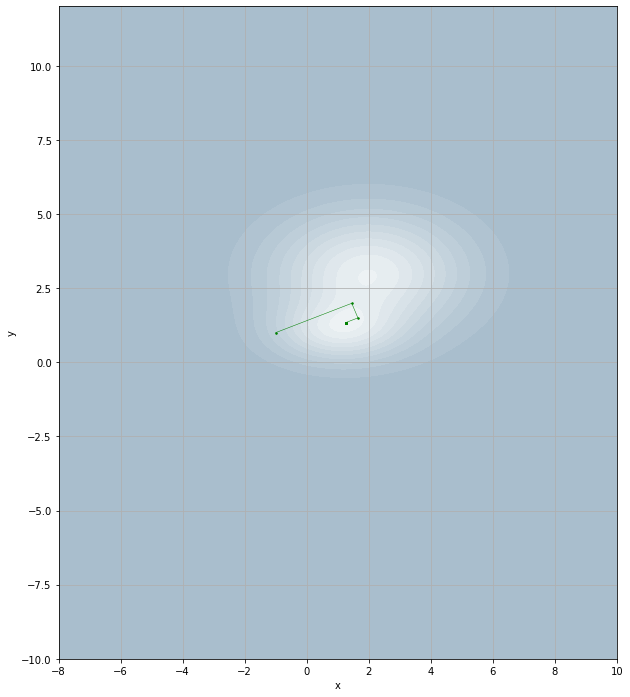

			Ответ : [1.26303503 1.33439594]. Количество итераций : 16. Время : 685324 микросекунд. Память : 66.272 KB
		 Метод сопряженных направлений Флетчера-Ривса:


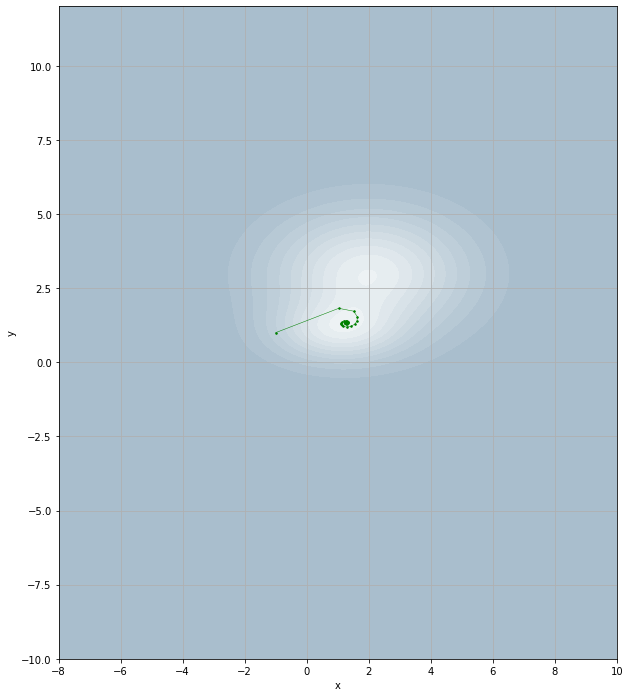

			Ответ : [1.26304183 1.33439862]. Количество итераций : 97. Время : 208752 микросекунд. Память : 85.809 KB

		 Метод Ньютона:


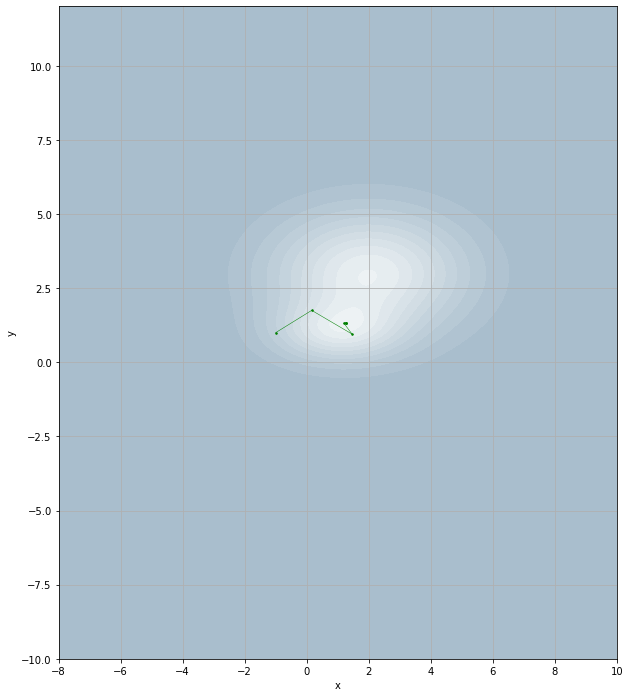

			Ответ:[1.26303502 1.33439596]. Количество итераций : 6. Время : 12198 микросекунд. Память : 11.264 KB
	x0=[2 3]
		 Метод градиентного спуска:


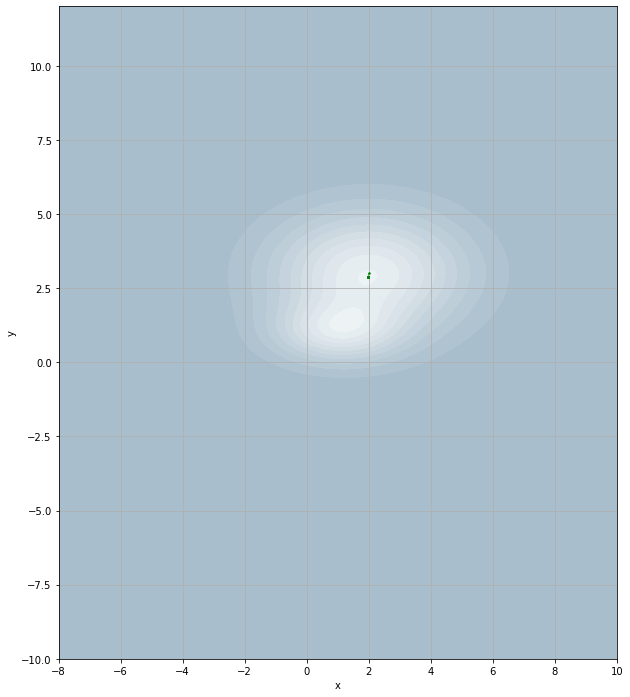

			Ответ : [1.96715157 2.88611472]. Количество итераций : 8. Время : 979715 микросекунд. Память : 64.148 KB
		 Метод сопряженных направлений Флетчера-Ривса:


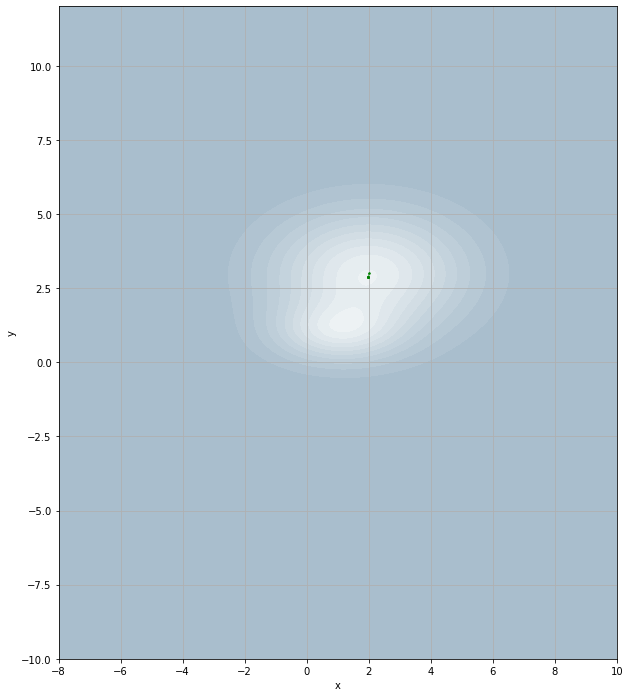

			Ответ : [1.9671543  2.88611373]. Количество итераций : 5. Время : 11616 микросекунд. Память : 8.449 KB

		 Метод Ньютона:


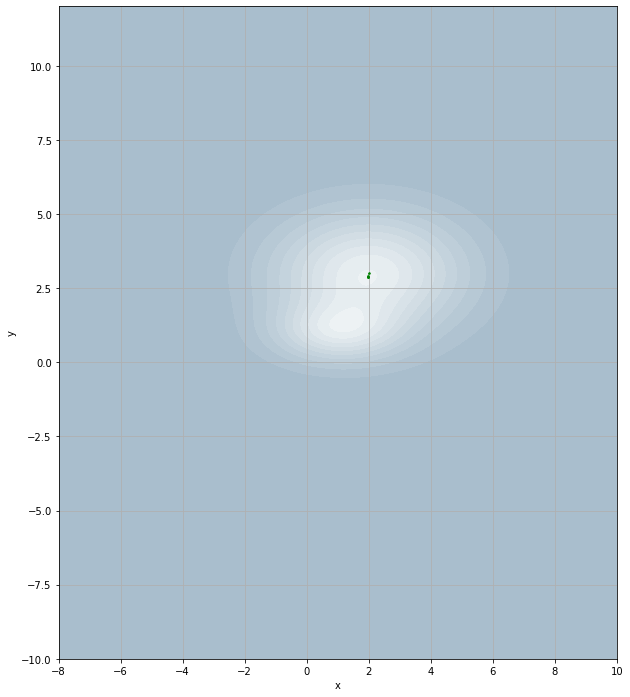

			Ответ:[1.96715142 2.88611471]. Количество итераций : 4. Время : 8697 микросекунд. Память : 1.416 KB
	x0=[4 1]
		 Метод градиентного спуска:


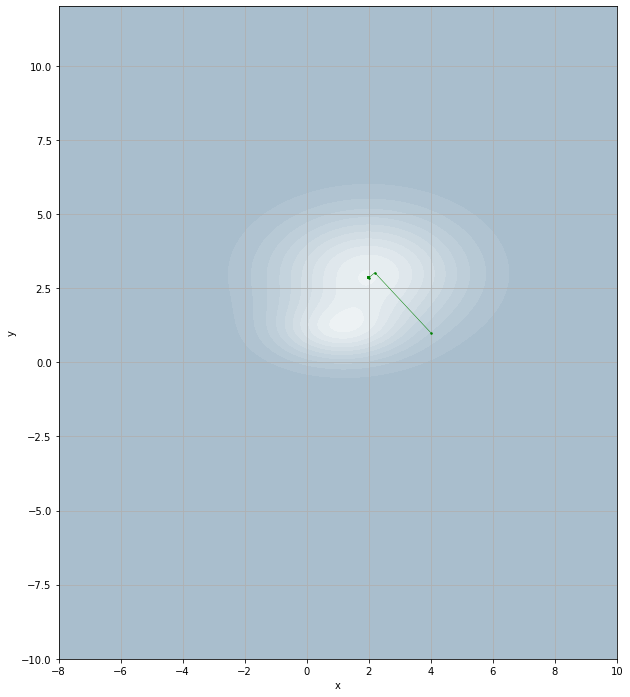

			Ответ : [1.96715148 2.88611476]. Количество итераций : 12. Время : 616664 микросекунд. Память : 67.606 KB
		 Метод сопряженных направлений Флетчера-Ривса:


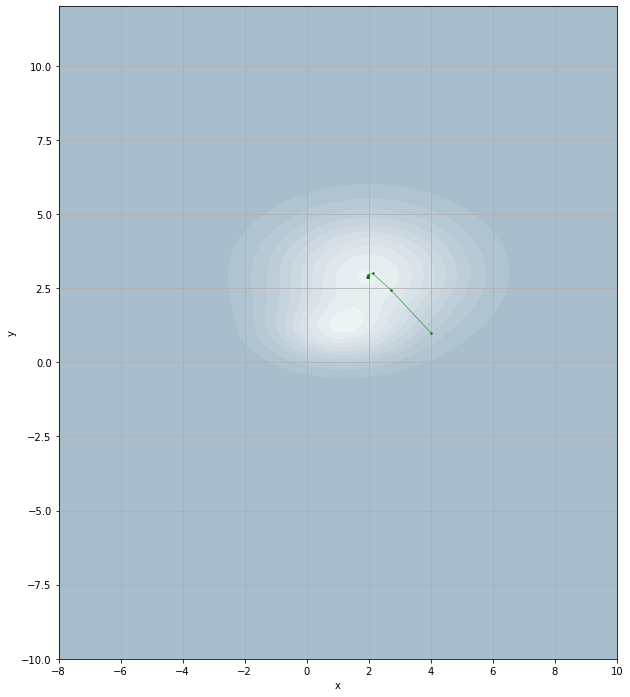

			Ответ : [1.96715037 2.8861151 ]. Количество итераций : 9. Время : 20117 микросекунд. Память : 12.481 KB

		 Метод Ньютона:


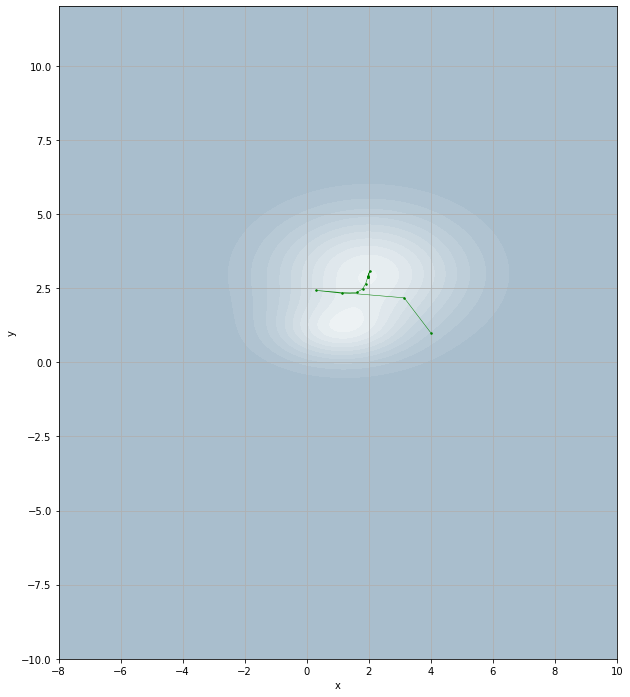

			Ответ:[1.96715142 2.88611471]. Количество итераций : 11. Время : 5940 микросекунд. Память : 6.728 KB
	x0=[3 5]
		 Метод градиентного спуска:


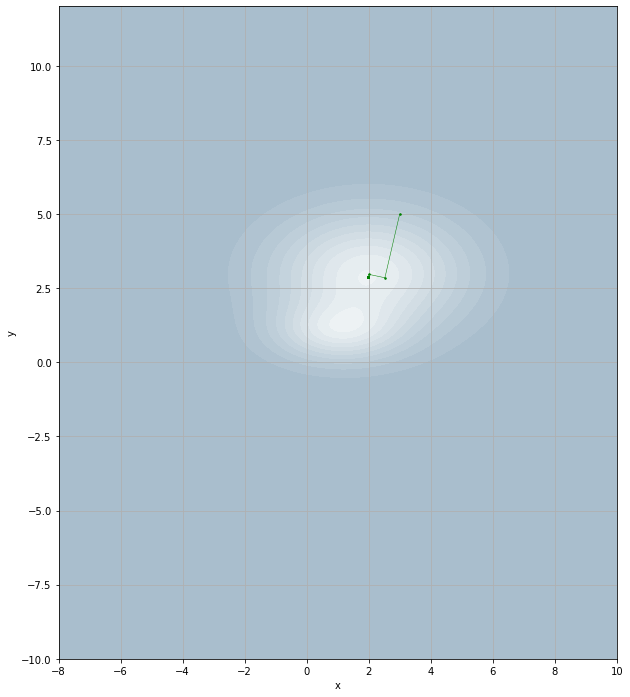

			Ответ : [1.96715141 2.88611475]. Количество итераций : 15. Время : 75128 микросекунд. Память : 67.25 KB
		 Метод сопряженных направлений Флетчера-Ривса:


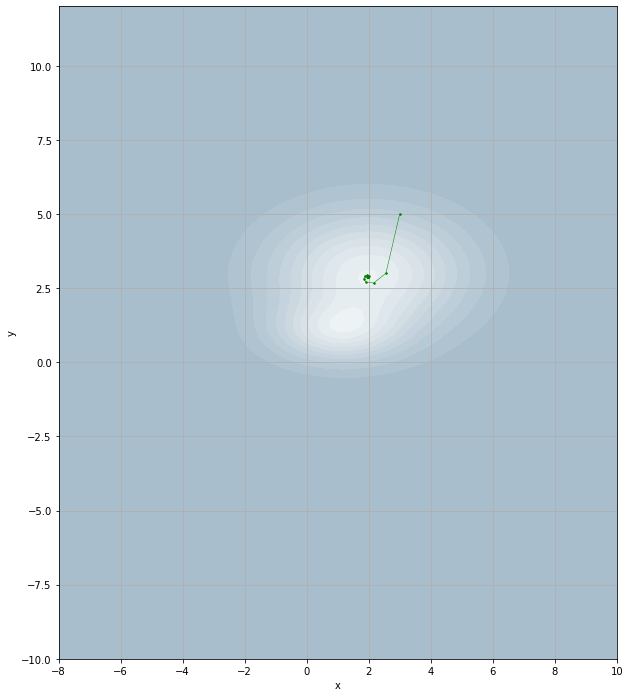

			Ответ : [1.96714469 2.88612204]. Количество итераций : 28. Время : 32727 микросекунд. Память : 34.457 KB

		 Метод Ньютона:


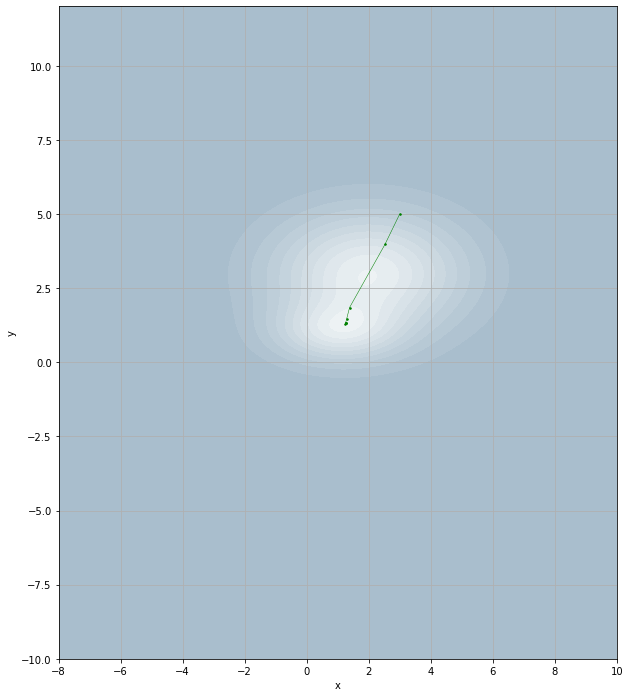

			Ответ:[1.26303502 1.33439596]. Количество итераций : 7. Время : 12662 микросекунд. Память : 6.472 KB


In [ ]:
warnings.filterwarnings('ignore')
representations = ["5 * (y - x) ^ 2 + (1 - x) ^ 2",
                   "(100 * (y - x ^ 2) ^ 2 + (1 - x) ^ 2)",
                   "2 * exp(-((x - 1) / 2) ^ 2 - (y - 1) ^ 2) + 3 * exp(-((x - 2) / 3) ^ 2 - ((y - 3) / 2) ^ 2)"]

fs = [lambda x, y: 5 * (y - x) ** 2 + (1 - x) ** 2,
      lambda x, y: 100 * (y - x ** 2) ** 2 + (1 - x) ** 2,
      lambda x, y: (-1) * (2 * np.exp(-((x - 1) / 2) ** 2 - (y - 1) ** 2) + 3 * np.exp(-((x - 2) / 3) ** 2 - ((y - 3) / 2) ** 2))]

derivatives = [lambda x, y: np.array([-10 * (y - x) + 2 * x - 2,  10 * (y - x)]),
              lambda x, y: np.array([2 * (-1 + x + 200 * x ** 3 - 200 * x * y),  200 * (-x ** 2 + y)]),
              lambda x, y: (-1.0) * np.array([2 * exp(-((x - 1) / 2) ** 2 - (y - 1) ** 2) * (-(x - 1) / 2) + 3 * exp(-((x - 2) / 3) ** 2 - ((y - 3) / 2) ** 2) * (2.0 / 3.0) * ( -(x - 2) / 3), 2 * exp(-((x - 1) / 2) ** 2 - (y - 1) ** 2) * (-2 * (y - 1)) + 3 * exp(-((x - 2) / 3) ** 2 - ((y - 3) / 2) ** 2) * (-((y - 3) / 2))])]

hessians = [lambda x, y: np.array([[202, -200], [-200, 200]]),
         lambda x, y: np.array([[-400 * ((y - x ** 2) - 2 * x ** 2) + 2, -400 * x], [-400 * x, 200]]),
         lambda x, y: (-1) * np.array(
                [[3 * ((4 / 81) * (x - 2) ** 2 * exp((-1 / 9) * (x - 2) ** 2 - (1 / 4) * (y - 3) ** 2) -
                    (2 / 9) * exp((-1 / 9) * (x - 2) ** 2 - (1 / 4) * (y - 3) ** 2)) +
                2 * ((1 / 4) * (x - 1) ** 2 * exp((-(1 / 4) * (1 - x) ** 2 - (y - 1) ** 2)) -
                    (1 / 2) * exp(-(1 / 4) * (1 - x) ** 2 - (y - 1) ** 2)),
                (1 / 3) * (x - 2) * (y - 3) * exp(-(1 / 9) * (x - 2) ** 2 - (1 / 4) * (y - 3) ** 2) +
                2 * (x - 1) * (y - 1) * exp(-(1 / 4) * (x - 1) ** 2 - (y - 1) ** 2)],
                [(1 / 3) * (x - 2) * (y - 3) * exp(-(1 / 9) * (x - 2) ** 2 - (1 / 4) * (y - 3) ** 2) +
                2 * (x - 1) * (y - 1) * exp(-(1 / 4) * (x - 1) ** 2 - (y - 1) ** 2),
                3 * ((1 / 4) * (y - 3) ** 2 * exp((-1 / 9) * (x - 2) ** 2 - (1 / 4) * (3 - y) ** 2) -
                    (1 / 2) * exp((-1 / 9) * (x - 2) ** 2 - (1 / 4) * (3 - y) ** 2)) +
                2 * (4 * (y - 1) ** 2 * exp((-1 / 4) * (x - 1) ** 2 - (y - 1) ** 2) -
                    2 * exp((-1 / 4) * (x - 1) ** 2 - (y - 1) ** 2))]])]

starts = np.array([[0, 0], [-1, 1], [2, 3], [4, 1], [3, 5]])
for i, f in enumerate(fs):
  print(f'Вычисляю для f = {representations[i]}:')
  for s in starts :
    print(f'\tx0={s}')
    print(f'\t\t Метод градиентного спуска:')
    iter, time, memory, x, trace = gradient_descent(f, derivatives[i], fibonacci, s)
    plot_graph(f, trace)
    print(f'\t\t\tОтвет : {x}. Количество итераций : {iter}. Время : {time.microseconds} микросекунд. Память : {memory} KB')
    print(f'\t\t Метод сопряженных направлений Флетчера-Ривса:')
    iter, time, memory, trace, x = conjugate_gradient(f, derivatives[i], s, fibonacci, eps = 1e-5)
    if (x is None) :
      ans = "Разошелся"
    else : ans = x
    plot_graph(f, trace)
    print(f'\t\t\tОтвет : {ans}. Количество итераций : {iter}. Время : {time.microseconds} микросекунд. Память : {memory} KB')
    print(f'\n\t\t Метод Ньютона:')
    iter, time, memory, trace, x = newton(f, derivatives[i], hessians[i], s, eps = 1e-5)
    plot_graph(f, trace)
    print(f'\t\t\tОтвет:{x}. Количество итераций : {iter}. Время : {time.microseconds} микросекунд. Память : {memory} KB')